### **Keypoint Detection**

### Sift

In [5]:
import cv2 as cv
import numpy as np
import argparse
from matplotlib import pyplot as plt

TEST_IMG = "test.jpeg"

In [6]:
def split_img(img, rows, cols, inter_k):
    splits = []
    m_size, n_size = img.shape[0], img.shape[1]
    remain_r, remain_c = m_size % rows, n_size % cols

    for i in range(rows):
        row = []
        f_i, l_i = i == 0, i == cols - 1
        start_i = i * (m_size // rows) - (not f_i) * inter_k
        end_i = (i + 1) * (m_size // rows) + (not l_i) * inter_k

        for j in range(cols):
            f_j, l_j = j == 0, j == cols - 1
            start_j = j * (n_size // cols) - (not f_j) * inter_k
            end_j = (j + 1) * (n_size // cols) + (not l_j) * inter_k
            row.append(img[
                start_i:end_i + l_i * remain_r,
                start_j:end_j + l_j * remain_c
            ])    
        splits.append(row)
            
    return splits

In [30]:
# need to reverse channel order for rgb
def show_splits(splits, title=None, **kwargs):
    rows = len(splits)
    cols = len(splits[0])
    
    fig, axes = plt.subplots(
        rows, cols, sharex=True, sharey=True, figsize=(20,10)
    )

    if rows == 1 and cols == 1:
        axes.imshow(splits[0][0], **kwargs)
        if title:
            axes.set_title(title)
        return

    for i in range(rows):
        for j in range(cols):
            if rows == 1:
                axes[j].imshow(splits[i][j], **kwargs)
                axes[j].set_title(f"Split {j}")
            else:
                axes[i,j].imshow(splits[i][j], **kwargs)
                axes[i,j].set_title(f"Split {i}, {j}")

# show_splits(splits, cmap='gray')
# plt.figure(figsize = (20,10))
# plt.imshow(splits[0][0], cmap='gray')

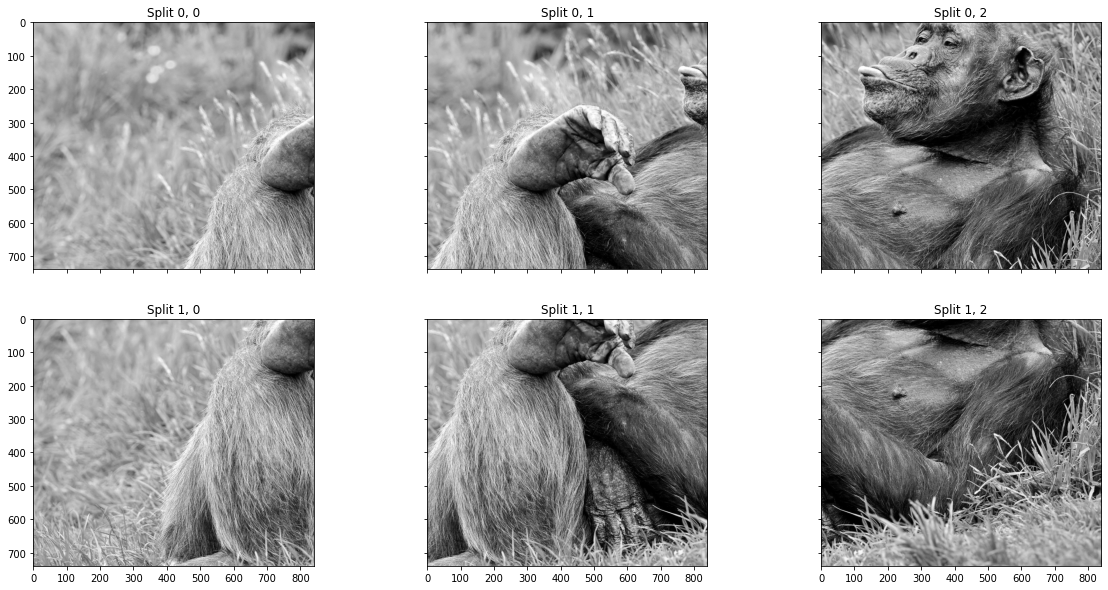

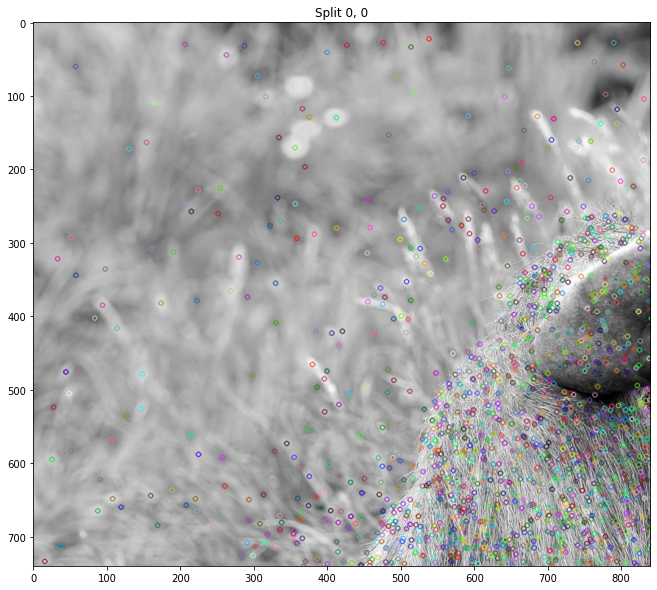

In [32]:
src = cv.imread(TEST_IMG)

if src is None:
    print('Could not open or find the image:', TEST_IMG)
    exit(0)
img = src.copy()
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)


sift = cv.SIFT_create()
keypoints = sift.detect(gray)

# cv.drawKeypoints(gray, keypoints, img)
# img = cv.drawKeypoints(
#     gray, keypoints, img,
#     flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
# )

r_split = 2
c_split = 3
splits = split_img(gray, r_split, c_split, 200)
sample_split = splits[0][0]

sample_split = cv.drawKeypoints(sample_split, keypoints, img)

show_splits(splits, cmap='gray')
show_splits([[sample_split]], title="Split 0, 0", cmap='gray')



In [ ]:
## Show that it is invariant